In [1]:
import librosa
import librosa.display as librosa_display
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

import IPython

Загрузим датасет с кагла:

P.S.: он огромный, поэтому загружать его заново каждый раз - плохая идея.

In [2]:
# import kaggle

# kaggle.api.authenticate()

# kaggle.api.dataset_download_files('vinayshanbhag/bird-song-data-set', path='data/birds', unzip=True)

In [3]:
df = pd.read_csv('data/birds/bird_songs_metadata.csv')[['id', 'species', 'filename']]

df['species'].unique()

array(['bewickii', 'polyglottos', 'migratorius', 'melodia', 'cardinalis'],
      dtype=object)

Будем решать задачу классификации между типами **bewickii** и **cardinalis**: 

In [4]:
df.drop(df[(df.species != 'cardinalis') & (df.species != 'bewickii')].index, inplace=True)

df['species'].unique()

array(['bewickii', 'cardinalis'], dtype=object)

Теперь прочитаем соответствующие записи голосов:

In [5]:
WAV_PREFIX = 'data/birds/wavfiles/'

speechs = []

for file in df['filename']:
    wave, _ = librosa.load(WAV_PREFIX + file)
    speechs.append(torch.Tensor(wave))

Я хотел заиспользовать tonnetz здесь, но я его не понимаю, потом хотел выбрать темпограмму, но темпограмма не сжимает данные, в итоге выбрал zero_crossing_rate, потому что он понятный, считается быстро и вообще судо что такое.

In [6]:
def transform(audio):
    return librosa.feature.zero_crossing_rate(audio.numpy()).reshape(-1)

mels = np.array([transform(audio) for audio in tqdm(speechs)])

  0%|          | 0/1967 [00:00<?, ?it/s]

In [7]:
def create_colors(species):
    res = []
    for specie in species:
        if (specie == 'bewickii'):
            res.append('indianred')
        elif (specie == 'cardinalis'):
            res.append('royalblue')
        else:
            res.append('red')
    return res    

colors = create_colors(df['species'])

Попробуем записать наши признаки в тензорборд и покрутить маппинги:

In [8]:
from torch.utils.tensorboard import SummaryWriter

# Hackity hack
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

with SummaryWriter() as writer:
    writer.add_embedding(mels, metadata=colors)

In [9]:
%load_ext tensorboard
%tensorboard --logdir runs

По результатам долгого использования метода тыка, воспользуемся TSNE и UMAP для разделение голосов птиц.

In [10]:
from umap import UMAP

umap_embs = UMAP(
    n_components = 3,
    random_state = 42
).fit_transform(mels)

In [11]:
from sklearn.manifold import TSNE

tsne_embs = TSNE(
    n_components = 3,
    perplexity = 25,
    learning_rate = 1,
    init = 'pca',
    n_jobs = 4
).fit_transform(mels)

/home/covariance/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


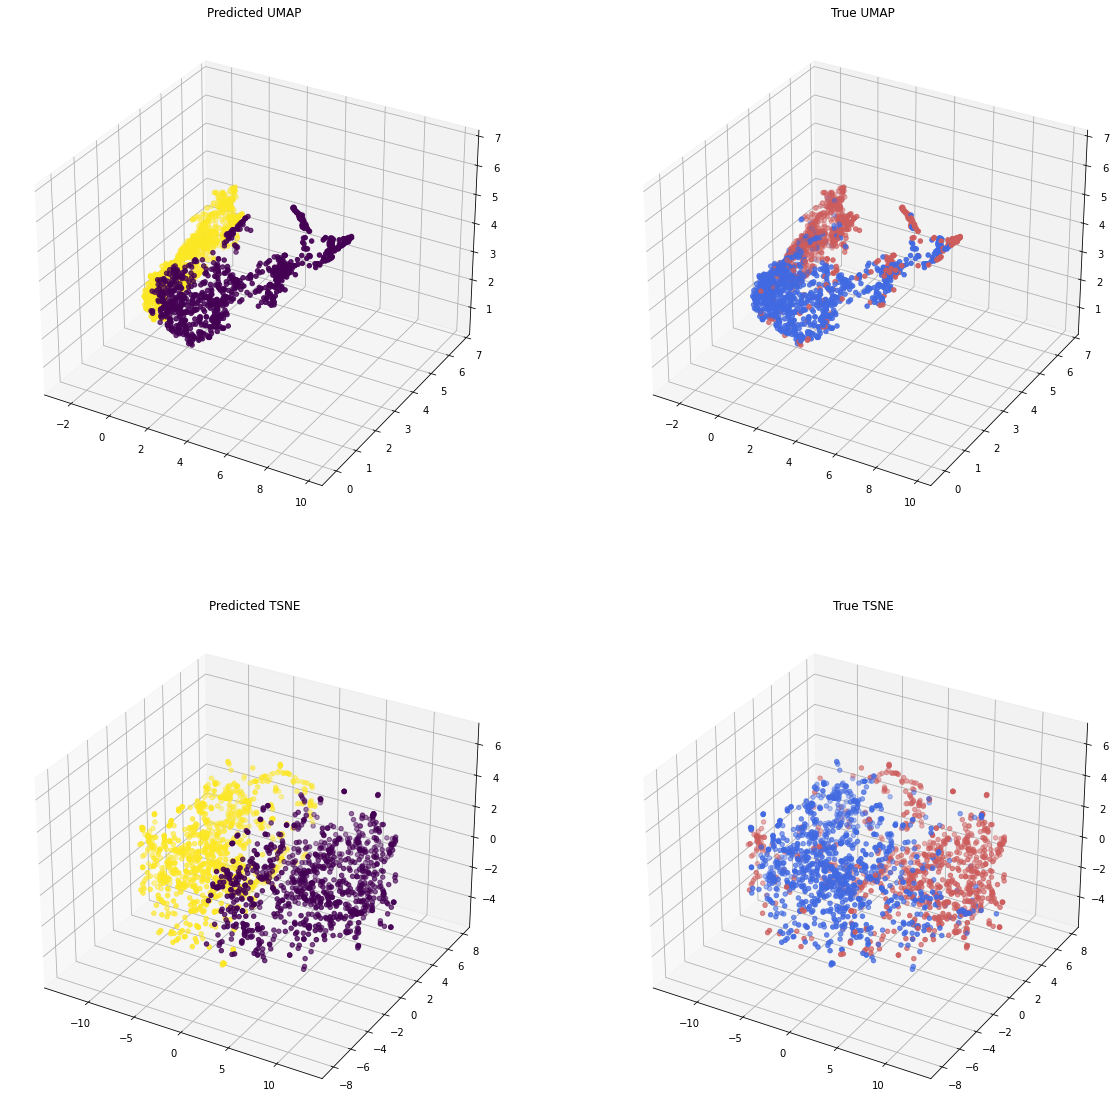

In [12]:
from sklearn.cluster import KMeans

tsne_pred = KMeans(n_clusters=2).fit_predict(tsne_embs)
umap_pred = KMeans(n_clusters=2).fit_predict(umap_embs)

_, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20,20), subplot_kw = {'projection' : '3d'})

ax0.scatter3D(umap_embs[:, 0], umap_embs[:, 1], umap_embs[:, 2], c=umap_pred)
ax0.set_title('Predicted UMAP')

ax1.scatter3D(umap_embs[:, 0], umap_embs[:, 1], umap_embs[:, 2], color=colors)
ax1.set_title('True UMAP')

ax2.scatter3D(tsne_embs[:, 0], tsne_embs[:, 1], tsne_embs[:, 2], c=tsne_pred)
ax2.set_title('Predicted TSNE')

ax3.scatter3D(tsne_embs[:, 0], tsne_embs[:, 1], tsne_embs[:, 2], color=colors)
ax3.set_title('True TSNE')

plt.show()

Модели без учителя справляются с разделением довольно плохо, однако на лейблах UMAP-а видно, что он достаточно хорошо разделим, и если не линейно, то уж нейросетью-то точно.

In [13]:
def get_most_similar(file):
    wave, _ = librosa.load(WAV_PREFIX + file)
    vec = transform(torch.Tensor(wave))

    ans = ''
    mx = -100
    for file_i in tqdm(df['filename']):
        if file_i != file:
            wave_i, _ = librosa.load(WAV_PREFIX + file_i)
            other_vec = transform(torch.Tensor(wave_i))
            result = np.dot(vec, other_vec) / (np.linalg.norm(vec) * np.linalg.norm(other_vec))  
            if result > mx and file_i != file:
                mx = result
                ans = file_i
    return ans

In [14]:
file = str(df.iloc[0]['filename'])
print(file)
IPython.display.Audio(WAV_PREFIX + file)

557838-0.wav


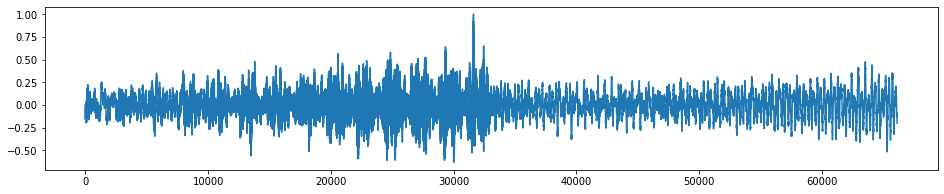

In [15]:
waveform, _ = librosa.load(WAV_PREFIX + file)

plt.figure(figsize=(16, 3))
plt.plot(waveform)
plt.show()

In [16]:
most_sim = get_most_similar(file)
print(most_sim)
IPython.display.Audio(WAV_PREFIX + most_sim)

  0%|          | 0/1967 [00:00<?, ?it/s]

557838-17.wav


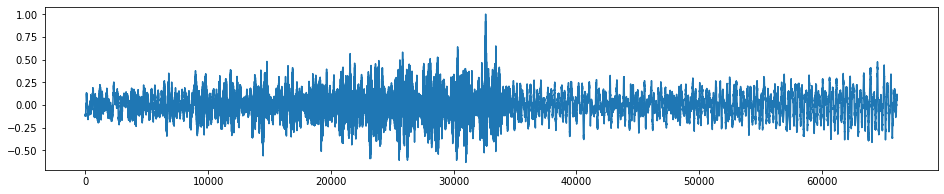

In [17]:
waveform, _ = librosa.load(WAV_PREFIX + most_sim)

plt.figure(figsize=(16, 3))
plt.plot(waveform)
plt.show()

That's all, folks!